<a href="https://colab.research.google.com/github/chamathjh/retail_credit_scorecard/blob/main/retail_credit_scorecard_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Develop a retail credit scoring model for Probability of Default (PD) assessment using logistic regression, incorporating Weight of Evidence (WoE) and Information Value (IV) for feature selection and transformation, and construct a scorecard based on the model.

**1 CARDHLDR ** Dummy variable, 1 if application for credit card accepted, 0 if not

**2 DEFAULT ** 1 if defaulted 0 if not (observed when CARDHLDR=1, 10,499 observations)

**3 AGE ** Age in years plus twelfths of a year

**4 ACADMOS ** months living at current address

5 ADEPCNT 1 + number of dependents

6 MAJORDRG Number of major derogatory reports

7 MINORDRG Number of minor derogatory reports

8 OWNRENT 1 if owns their home, 0 if rent

**9 INCOME ** Monthly income (divided by 10,000)

10 SELFEMPL 1 if self employed, 0 if not

**11 INCPER ** Income divided by number of dependents

12 EXP_INC Ratio of monthly credit card expenditure to yearly income

13 SPENDING Average monthly credit card expenditure (for CARDHOLDER = 1)

14 LOGSPEND Log of spending

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("surekharamireddy/credit-data")

print("Path to dataset files:", path)

100%|██████████| 321k/321k [00:00<00:00, 55.3MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/surekharamireddy/credit-data/versions/1


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv(f"{path}/credit_data.csv")
df.head()



,CARDHLDR,DEFAULT,AGE,ACADMOS,ADEPCNT,MAJORDRG,MINORDRG,OWNRENT,INCOME,SELFEMPL,INCPER,EXP_INC,SPENDING,LOGSPEND
0,0,0,27.250000,4,0,0,0,0,1200.000000,0,18000.0,0.000667,,
1,0,0,40.833332,111,3,0,0,1,4000.000000,0,13500.0,0.000222,,
2,1,0,37.666668,54,3,0,0,1,3666.666667,0,11300.0,0.033270,121.9896773,4.8039364
3,1,0,42.500000,60,3,0,0,1,2000.000000,0,17250.0,0.048427,96.8536213,4.5732008
4,1,0,21.333334,8,0,0,0,0,2916.666667,0,35000.0,0.016523,48.1916700,3.8751862


In [ ]:
df_final = df[df['CARDHLDR']==1]

display(df_final.head())

df_final.count()

,CARDHLDR,DEFAULT,AGE,ACADMOS,ADEPCNT,MAJORDRG,MINORDRG,OWNRENT,INCOME,SELFEMPL,INCPER,EXP_INC,SPENDING,LOGSPEND
2,1,0,37.666668,54,3,0,0,1,3666.666667,0,11300.0,0.033270,121.9896773,4.8039364
3,1,0,42.500000,60,3,0,0,1,2000.000000,0,17250.0,0.048427,96.8536213,4.5732008
4,1,0,21.333334,8,0,0,0,0,2916.666667,0,35000.0,0.016523,48.1916700,3.8751862
5,1,0,20.833334,78,1,0,0,0,1750.000000,0,11750.0,0.031323,54.8159555,4.0039813
6,1,0,62.666668,25,1,0,0,1,5250.000000,0,36500.0,0.039269,206.1624667,5.3286645


,0
CARDHLDR,10499
DEFAULT,10499
AGE,10499
ACADMOS,10499
ADEPCNT,10499
MAJORDRG,10499
MINORDRG,10499
OWNRENT,10499
INCOME,10499
SELFEMPL,10499


In [ ]:
default_dist = df_final['DEFAULT'].value_counts(normalize=True)
display(default_dist)

df_final.isnull().sum()

,proportion
DEFAULT,
0,0.905134
1,0.094866


,0
CARDHLDR,0
DEFAULT,0
AGE,0
ACADMOS,0
ADEPCNT,0
MAJORDRG,0
MINORDRG,0
OWNRENT,0
INCOME,0
SELFEMPL,0


In [ ]:
drop_vars = [
    "CARDHLDR",
    "SPENDING",
    "EXP_INC"
]

df_final = df_final.drop(columns=drop_vars)

In [ ]:
display(df_final)

,DEFAULT,AGE,ACADMOS,ADEPCNT,MAJORDRG,MINORDRG,OWNRENT,INCOME,SELFEMPL,INCPER
2,0,37.666668,54,3,0,0,1,3666.666667,0,11300.000000
3,0,42.500000,60,3,0,0,1,2000.000000,0,17250.000000
4,0,21.333334,8,0,0,0,0,2916.666667,0,35000.000000
5,0,20.833334,78,1,0,0,0,1750.000000,0,11750.000000
6,0,62.666668,25,1,0,0,1,5250.000000,0,36500.000000
...,...,...,...,...,...,...,...,...,...,...
13438,0,33.500000,24,0,0,0,0,1800.000000,0,21600.000000
13439,0,41.750000,12,1,0,0,0,2083.333333,1,12500.000000
13440,0,48.500000,66,1,0,1,1,2583.333333,0,15500.000000
13441,0,48.250000,2,2,0,0,1,3083.333333,0,12333.333008


In [ ]:
target = "DEFAULT"

X = df_final.drop(columns=[target])
y = df_final[target]

In [ ]:
!pip install scorecardpy
import scorecardpy as sc

bins = sc.woebin(df_final, y=target)


[INFO] creating woe binning ...


/usr/local/lib/python3.12/dist-packages/scorecardpy/condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/usr/local/lib/python3.12/dist-packages/scorecardpy/condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/usr/local/lib/python3.12/dist-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=Fals

In [ ]:
bins_df = pd.concat(bins.values())

display(bins_df)

for variable, table in bins.items():
    print(f"--- Binning Table for: {variable} ---")
    display(table)

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,SELFEMPL,"[-inf,1.0)",9936,0.946376,8986,950,0.095612,0.008654,0.000071,0.001417,1.0,False
1,SELFEMPL,"[1.0,inf)",563,0.053624,517,46,0.081705,-0.163786,0.001346,0.001417,inf,False
0,ACADMOS,"[-inf,15.0)",3053,0.290790,2776,277,0.090730,-0.049133,0.000688,0.013832,15.0,False
1,ACADMOS,"[15.0,20.0)",721,0.068673,666,55,0.076283,-0.238341,0.003542,0.013832,20.0,False
2,ACADMOS,"[20.0,75.0)",4223,0.402229,3781,442,0.104665,0.109182,0.005012,0.013832,75.0,False
3,ACADMOS,"[75.0,145.0)",1467,0.139728,1325,142,0.096796,0.022275,0.000070,0.013832,145.0,False
4,ACADMOS,"[145.0,inf)",1035,0.098581,955,80,0.077295,-0.224069,0.004520,0.013832,inf,False
0,OWNRENT,"[-inf,1.0)",5469,0.520907,4854,615,0.112452,0.189679,0.020236,0.046479,1.0,False
1,OWNRENT,"[1.0,inf)",5030,0.479093,4649,381,0.075746,-0.245992,0.026243,0.046479,inf,False
0,AGE,"[-inf,22.0)",646,0.061530,512,134,0.207430,0.915131,0.073815,0.098984,22.0,False


--- Binning Table for: SELFEMPL ---


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,SELFEMPL,"[-inf,1.0)",9936,0.946376,8986,950,0.095612,0.008654,0.000071,0.001417,1.0,False
1,SELFEMPL,"[1.0,inf)",563,0.053624,517,46,0.081705,-0.163786,0.001346,0.001417,inf,False


--- Binning Table for: ACADMOS ---


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,ACADMOS,"[-inf,15.0)",3053,0.290790,2776,277,0.090730,-0.049133,0.000688,0.013832,15.0,False
1,ACADMOS,"[15.0,20.0)",721,0.068673,666,55,0.076283,-0.238341,0.003542,0.013832,20.0,False
2,ACADMOS,"[20.0,75.0)",4223,0.402229,3781,442,0.104665,0.109182,0.005012,0.013832,75.0,False
3,ACADMOS,"[75.0,145.0)",1467,0.139728,1325,142,0.096796,0.022275,0.000070,0.013832,145.0,False
4,ACADMOS,"[145.0,inf)",1035,0.098581,955,80,0.077295,-0.224069,0.004520,0.013832,inf,False


--- Binning Table for: OWNRENT ---


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,OWNRENT,"[-inf,1.0)",5469,0.520907,4854,615,0.112452,0.189679,0.020236,0.046479,1.0,False
1,OWNRENT,"[1.0,inf)",5030,0.479093,4649,381,0.075746,-0.245992,0.026243,0.046479,inf,False


--- Binning Table for: AGE ---


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AGE,"[-inf,22.0)",646,0.061530,512,134,0.207430,0.915131,0.073815,0.098984,22.0,False
1,AGE,"[22.0,30.0)",3909,0.372321,3514,395,0.101049,0.069991,0.001876,0.098984,30.0,False
2,AGE,"[30.0,36.0)",2219,0.211353,2035,184,0.082920,-0.147700,0.004343,0.098984,36.0,False
3,AGE,"[36.0,inf)",3725,0.354796,3442,283,0.075973,-0.242746,0.018950,0.098984,inf,False


--- Binning Table for: INCOME ---


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,INCOME,"[-inf,1600.0)",1874,0.178493,1566,308,0.164354,0.629435,0.090920,0.22821,1600.0,False
1,INCOME,"[1600.0,2100.0)",2687,0.255929,2381,306,0.113882,0.203925,0.011558,0.22821,2100.0,False
2,INCOME,"[2100.0,2600.0)",2042,0.194495,1872,170,0.083252,-0.143349,0.003771,0.22821,2600.0,False
3,INCOME,"[2600.0,4300.0)",2963,0.282217,2783,180,0.060749,-0.482712,0.054127,0.22821,4300.0,False
4,INCOME,"[4300.0,inf)",933,0.088866,901,32,0.034298,-1.082154,0.067833,0.22821,inf,False


--- Binning Table for: ADEPCNT ---


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,ADEPCNT,"[-inf,1.0)",5395,0.513858,4900,495,0.091752,-0.036817,0.000686,0.009758,1.0,False
1,ADEPCNT,"[1.0,2.0)",2050,0.195257,1825,225,0.109756,0.162381,0.005498,0.009758,2.0,False
2,ADEPCNT,"[2.0,3.0)",1501,0.142966,1353,148,0.098601,0.042748,0.000266,0.009758,3.0,False
3,ADEPCNT,"[3.0,inf)",1553,0.147919,1425,128,0.082421,-0.154281,0.003308,0.009758,inf,False


--- Binning Table for: MAJORDRG ---


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,MAJORDRG,"[-inf,1.0)",9361,0.891609,8495,866,0.092511,-0.027733,0.000678,0.00575,1.0,False
1,MAJORDRG,"[1.0,inf)",1138,0.108391,1008,130,0.114236,0.207427,0.005072,0.00575,inf,False


--- Binning Table for: MINORDRG ---


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,MINORDRG,"[-inf,1.0)",8960,0.853415,8152,808,0.090179,-0.055841,0.002602,0.015808,1.0,False
1,MINORDRG,"[1.0,inf)",1539,0.146585,1351,188,0.122157,0.283457,0.013206,0.015808,inf,False


--- Binning Table for: INCPER ---


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,INCPER,"[-inf,11000.0)",1891,0.180112,1626,265,0.140137,0.441467,0.041922,0.091089,11000.0,False
1,INCPER,"[11000.0,22000.0)",4039,0.384703,3627,412,0.102005,0.080478,0.002574,0.091089,22000.0,False
2,INCPER,"[22000.0,41000.0)",3715,0.353843,3444,271,0.072948,-0.286654,0.025892,0.091089,41000.0,False
3,INCPER,"[41000.0,inf)",854,0.081341,806,48,0.056206,-0.565267,0.020702,0.091089,inf,False


In [ ]:
iv_df = sc.iv(df_final, y=target)
iv_df.sort_values("info_value", ascending=False)

,variable,info_value
8,INCPER,1.072541
4,INCOME,1.008965
3,AGE,0.613569
1,ACADMOS,0.254845
2,OWNRENT,0.046479
7,MINORDRG,0.018087
5,ADEPCNT,0.013703
6,MAJORDRG,0.011045
0,SELFEMPL,0.001417


In [ ]:
selected_vars = iv_df[iv_df["info_value"] >= 0.02]["variable"].tolist()
selected_vars

['INCPER', 'INCOME', 'AGE', 'ACADMOS', 'OWNRENT']

{'AGE': <Figure size 640x480 with 2 Axes>}

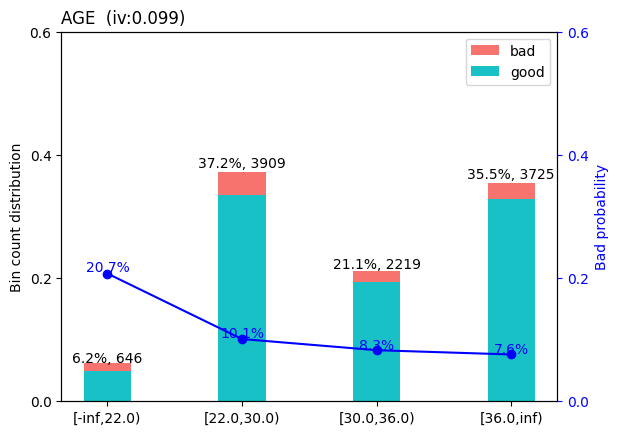

In [ ]:
sc.woebin_plot(bins["AGE"])

{'INCPER': <Figure size 640x480 with 2 Axes>}

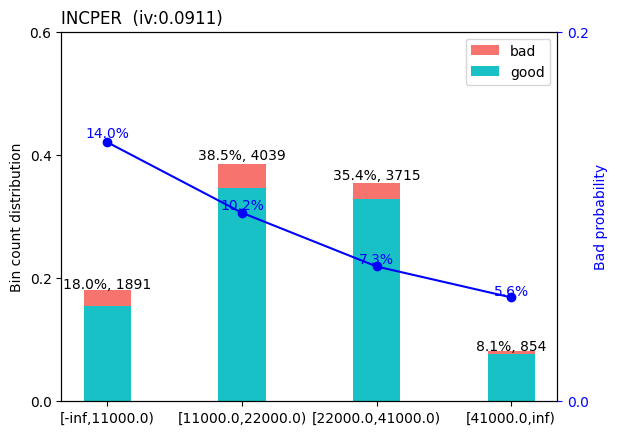

In [ ]:
sc.woebin_plot(bins["INCPER"])

{'INCOME': <Figure size 640x480 with 2 Axes>}

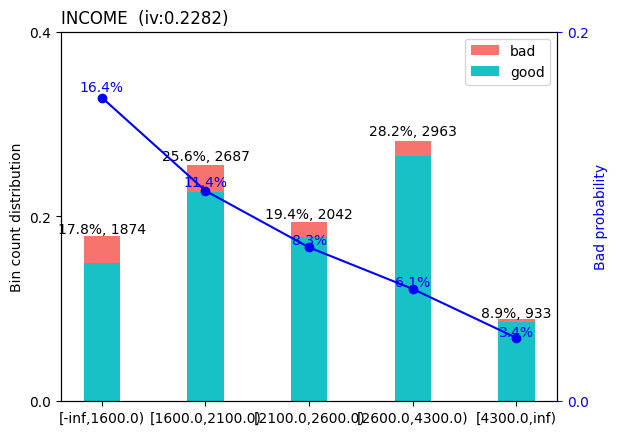

In [ ]:
sc.woebin_plot(bins["INCOME"])

{'ACADMOS': <Figure size 640x480 with 2 Axes>}

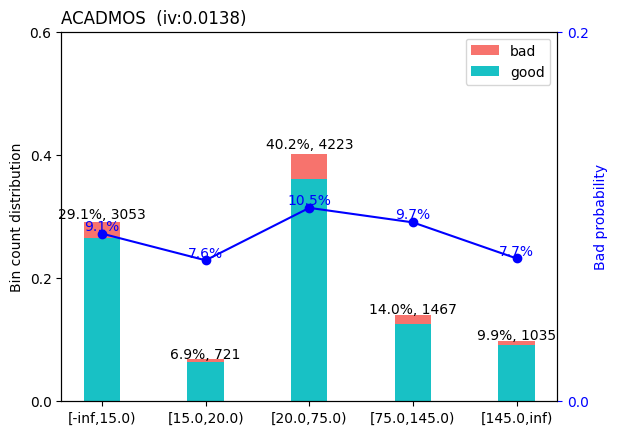

In [ ]:
sc.woebin_plot(bins["ACADMOS"])

{'OWNRENT': <Figure size 640x480 with 2 Axes>}

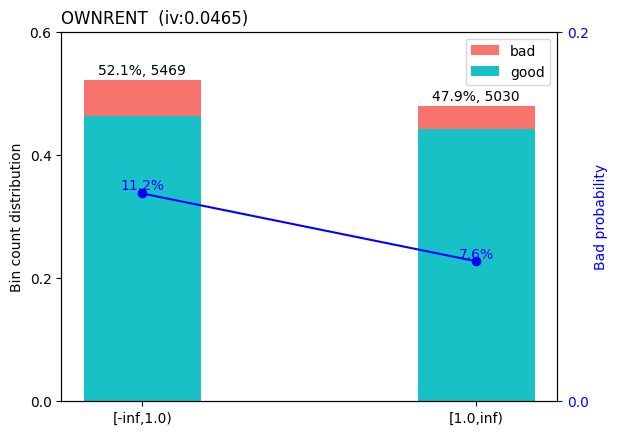

In [ ]:
sc.woebin_plot(bins["OWNRENT"])